In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset for Flare7K++
class FlareDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.input_images = []
        self.gt_images = []

        # Populate list of input and ground truth image paths
        real_dir = os.path.join(root_dir, 'test_data', 'real')

        # Load real images
        self.input_images += [os.path.join(real_dir, 'input', img) for img in os.listdir(os.path.join(real_dir, 'input'))]
        self.gt_images += [os.path.join(real_dir, 'gt', img) for img in os.listdir(os.path.join(real_dir, 'gt'))]

    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        input_image = Image.open(self.input_images[idx]).convert("RGB")
        gt_image = Image.open(self.gt_images[idx]).convert("RGB")

        if self.transform:
            input_image = self.transform(input_image)
            gt_image = self.transform(gt_image)

        return input_image, gt_image

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Load dataset and create DataLoader
dataset = FlareDataset(root_dir='/content/drive/MyDrive/Flare7K++', transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from PIL import Image
import os

# Define a Residual Block for Generator
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.block(x)

# Updated Generator with Residual Blocks
class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(Generator, self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=1, padding=3),
            nn.ReLU(inplace=True)
        )

        self.downsample = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(256) for _ in range(6)]
        )

        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.final = nn.Sequential(
            nn.Conv2d(64, out_channels, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.downsample(x)
        x = self.residual_blocks(x)
        x = self.upsample(x)
        return self.final(x)

# Discriminator (unchanged)
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0)
        )

    def forward(self, x):
        return self.model(x)

# Perceptual Loss using VGG19
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg19(pretrained=True).features
        self.layers = nn.Sequential(*list(vgg[:12])).eval()
        for param in self.layers.parameters():
            param.requires_grad = False

    def forward(self, gen_image, target_image):
        gen_features = self.layers(gen_image)
        target_features = self.layers(target_image)
        return nn.functional.l1_loss(gen_features, target_features)

# Training process with perceptual loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models and loss functions
generator = Generator().to(device)
discriminator = Discriminator().to(device)
perceptual_loss = PerceptualLoss().to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss functions
adversarial_loss = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()

# Training process with perceptual loss
num_epochs = 200  # Increase epochs
for epoch in range(1, num_epochs + 1):
    for i, (input_image, target_image) in enumerate(dataloader):
        input_image, target_image = input_image.to(device), target_image.to(device)

        # Update Generator
        optimizer_G.zero_grad()
        generated_image = generator(input_image)

        # Generator losses: adversarial, L1, and perceptual loss
        valid = torch.ones(input_image.size(0), 1, requires_grad=False).to(device)

        # Modify discriminator output to match the shape of 'valid'
        g_adv_loss = adversarial_loss(discriminator(generated_image).mean(dim=(2, 3)), valid)

        g_l1_loss = l1_loss(generated_image, target_image)
        g_perceptual_loss = perceptual_loss(generated_image, target_image)

        g_loss = g_adv_loss + 10 * g_l1_loss + g_perceptual_loss  # Adjusted weights
        g_loss.backward()
        optimizer_G.step()

        # Update Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(target_image).mean(dim=(2, 3)), valid)
        fake = torch.zeros(input_image.size(0), 1, requires_grad=False).to(device)
        fake_loss = adversarial_loss(discriminator(generated_image.detach()).mean(dim=(2, 3)), fake)

        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    # Log losses every epoch
    print(f"Epoch [{epoch}/{num_epochs}] - Generator Loss: {g_loss.item():.4f}, Discriminator Loss: {d_loss.item():.4f}")



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/200] - Generator Loss: 3.3380, Discriminator Loss: 0.6678
Epoch [2/200] - Generator Loss: 4.8091, Discriminator Loss: 0.6247
Epoch [3/200] - Generator Loss: 3.4767, Discriminator Loss: 0.7994
Epoch [4/200] - Generator Loss: 3.9650, Discriminator Loss: 0.6068
Epoch [5/200] - Generator Loss: 3.3098, Discriminator Loss: 0.5653
Epoch [6/200] - Generator Loss: 2.9180, Discriminator Loss: 0.6656
Epoch [7/200] - Generator Loss: 2.7364, Discriminator Loss: 0.7748
Epoch [8/200] - Generator Loss: 2.6119, Discriminator Loss: 0.5505
Epoch [9/200] - Generator Loss: 4.0092, Discriminator Loss: 1.0321
Epoch [10/200] - Generator Loss: 3.5760, Discriminator Loss: 0.4930
Epoch [11/200] - Generator Loss: 3.6516, Discriminator Loss: 0.7457
Epoch [12/200] - Generator Loss: 3.4223, Discriminator Loss: 0.6172
Epoch [13/200] - Generator Loss: 3.5458, Discriminator Loss: 0.5601
Epoch [14/200] - Generator Loss: 3.8218, Discriminator Loss: 0.6109
Epoch [15/200] - Generator Loss: 3.3598, Discriminator Lo

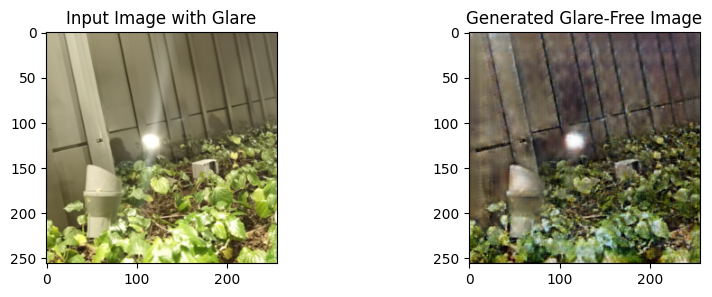

In [13]:
# Test and visualize results
def display_sample_images(dataset, generator):
    generator.eval()
    input_image, gt_image = dataset[6]  # Get the first sample
    input_image = input_image.unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        generated_image = generator(input_image).squeeze(0).cpu()

    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.title("Input Image with Glare")
    plt.imshow(input_image.squeeze(0).permute(1, 2, 0).cpu())
    plt.subplot(1, 2, 2)
    plt.title("Generated Glare-Free Image")
    plt.imshow(generated_image.permute(1, 2, 0))
    plt.show()

# Display some results from the dataset
display_sample_images(dataset, generator)